### Notebook aim: study alignment of RNN information and projection to integrator

In networks trained with a pretrained integrator incorporated into the structure of the network, integrator appears to be used to keep track of an agent's progress through a patch. The aim of this notebook is to study how the network projects the correct information to the integrator and how the network uses the output of the integrator. 

In [1]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    print(curr_file_path)
    sys.path.append(str(curr_file_path.parent))
    sys.path.append(os.path.join(str(curr_file_path.parent.parent.parent), 'fixed-point-finder'))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from agents.networks.a2c_rnn_split_vanilla import A2CRNN
from plot_utils import plot_fps
from copy import deepcopy as copy
from nb_analysis_tools import load_numpy, load_compressed_data, parse_all_sessions, gen_alignment_chart, find_odor_site_trajectories_by_patch_type
from aux_funcs import compressed_write, format_plot
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score
from numpy.linalg import norm
from imblearn.under_sampling import RandomUnderSampler


DATA_BASE_DIR = '../../results/rl_agent_outputs'
PATCH_TYPES_PER_ENV = 3
OBS_SIZE = PATCH_TYPES_PER_ENV + 1
ACTION_SIZE = 2
HIDDEN_SIZE = 128

# plt.rcParams['font.family'] = 'Helvetica Light'

C:\Users\david.bell\work\favorably_connected\code\notebooks


In [2]:
# Get cosine between two vectors
def cosine(u, v):
    return np.dot(u, v) / (norm(u)*norm(v))
    
# Load weights from given `load_path`
def load_network(load_path):
    
    network = A2CRNN(
        input_size=OBS_SIZE + ACTION_SIZE + 1,
        action_size=ACTION_SIZE,
        hidden_size=HIDDEN_SIZE,
        device='cpu',
        var_noise=0,
    )
    
    with torch.no_grad():
        saved_checkpoint = torch.load(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'), weights_only=False)
        if 'network_state_dict' in saved_checkpoint:
            network.load_state_dict(saved_checkpoint['network_state_dict'])
        else:
            network.load_state_dict(saved_checkpoint)
        network.eval()

    return network


# Load hidden states and behavior of network from `load path`
def load_hidden_and_behavior(load_path):
    data = load_numpy(os.path.join(DATA_BASE_DIR, load_path, 'hidden_state/*.npy').replace('\\','/'))
    data = np.transpose(data, [2, 1, 0])
    
    flattened_data = data.reshape(data.shape[0], data.shape[1] * data.shape[2], order='C')
    
    pca = PCA()
    pc_activities = pca.fit_transform(flattened_data.T)
    pc_activities = pc_activities.T.reshape(data.shape, order='C')
    
    all_session_data = parse_all_sessions(
        os.path.join(DATA_BASE_DIR, load_path, 'state'),
        30,
    )

    return data, pc_activities, all_session_data, pca

### Set of weights, hidden states, and behavior variables grabbed at different moments of training

In [3]:
weight_paths = [
    'he_init_vanilla_lr_2p5en5_clip_2025-06-13_17_05_58_437044_var_noise_0.0001_activity_weight_1/rnn_weights/02400.pth',
]

hidden_and_behavior_paths = [
    'test_he_init_linear_2025-06-16_18_04_27_837807_var_noise_0.0_activity_weight_1',
]


['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


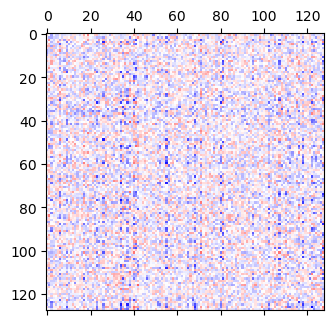

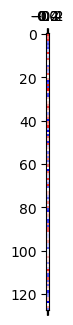

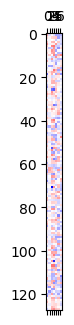

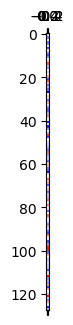

In [4]:
for i, (weight_path, hidden_and_behavior_path) in enumerate(zip(weight_paths, hidden_and_behavior_paths)):
    network = load_network(weight_path)
    hidden_activities, pc_activities, all_session_data, pca = load_hidden_and_behavior(hidden_and_behavior_path)
    
    weight_hh = network.rnn.weight_hh.detach().numpy()

    scale = 1.2
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

    m = np.abs(weight_hh).max()
    axs.matshow(weight_hh, vmin=-m, vmax=m, cmap='bwr')

    bias_hh = network.rnn.bias_hh.detach().numpy()

    scale = 1.2
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
    
    m = np.abs(bias_hh).max()
    axs.matshow(bias_hh[:, None], vmin=-m, vmax=m, cmap='bwr')

    weight_ih = network.rnn.weight_ih.detach().numpy()
    scale = 1.2
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
    m = np.abs(weight_ih).max()
    axs.matshow(weight_ih, vmin=-m, vmax=m, cmap='bwr')

    bias_ih = network.rnn.bias_ih.detach().numpy()
    scale = 1.2
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
    m = np.abs(bias_ih).max()
    axs.matshow(bias_ih[:, None], vmin=-m, vmax=m, cmap='bwr')

    
    


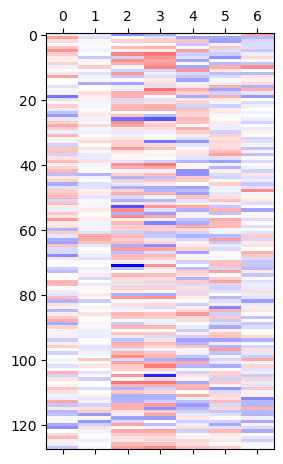

In [10]:
weight_ih = network.rnn.weight_ih.detach().numpy()
scale = 1.8
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
m = np.abs(weight_ih).max()
axs.matshow(weight_ih, vmin=-m, vmax=m, cmap='bwr', aspect=0.1)

In [11]:
def cosine(u, v):
    return np.dot(u, v) / (norm(u)*norm(v))

In [16]:
cosine(weight_ih[:, 2], weight_ih[:, 3])

0.44958895

In [17]:
cosine(weight_ih[:, 0], weight_ih[:, 3])

0.058175843

In [18]:
cosine(weight_ih[:, 0], weight_ih[:, 2])

0.016409205

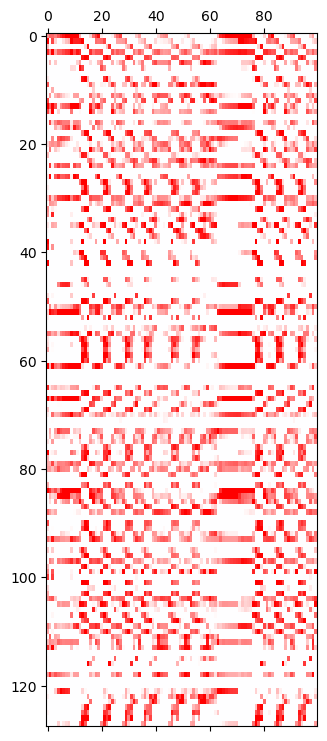

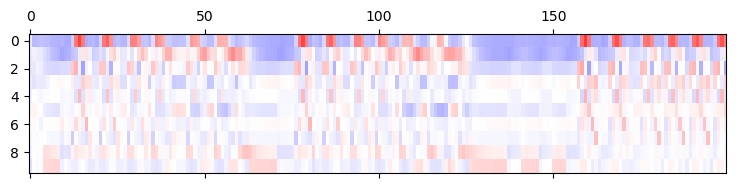

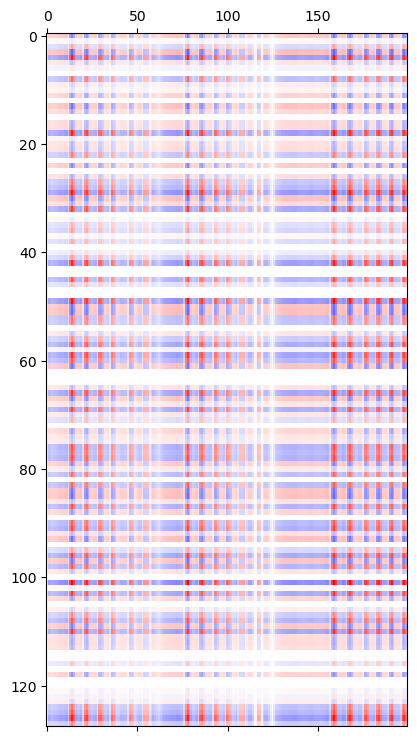

In [76]:
scale = 3
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.matshow(hidden_activities[:, 0, :100], vmin=-0.1, vmax=0.1, cmap='bwr', aspect=2)

scale = 3
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.matshow(pc_activities[:10, 0, :200], vmin=-0.7, vmax=0.7, cmap='bwr', aspect=4)

scale = 3
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.matshow(pca.components_[0, :, None] * pc_activities[None, 0, 0, :200], vmin=-0.1, vmax=0.1, cmap='bwr', aspect=3)

In [67]:
pc_1 = pca.components_[0, :]
a = np.abs(pc_1) > 0.1

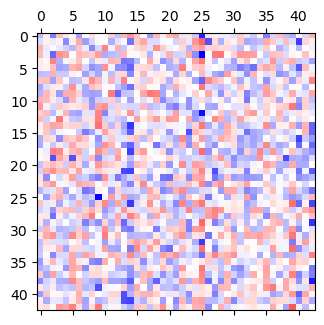

In [68]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

m = np.abs(weight_hh[a, :][:, a]).max()
axs.matshow(weight_hh[a, :][:, a], vmin=-m, vmax=m, cmap='bwr')